In [1]:
# Author: Michael Djaballah
# Last edited: 
# Last edited by: Michael Djaballah

import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 11:03 PM June 14, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format='%Y-%m-%d', data_path='data/'):
    date_format2 = 
    get_snp_store(data_path=data_path)
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format2)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)


def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns

In [3]:
from portfolio import Portfolio

In [76]:
universe = build_snp('2015-01-01')

ValueError: time data 'May 22, 2020' does not match format '%Y-%m-%d'

In [75]:
universe = build_snp('January 1, 2015', '%B %d, %Y')

In [41]:
start_date = '2015-01-01'
end_date = '2019-12-01'

hist_depth = 24
train_depth = 6

In [42]:
%%time
port = Portfolio(universe, hist_depth=hist_depth, 
                 train_depth=train_depth, features = ['Close', 'Volume'])
port.blacklist.add('BKR')
port.blacklist.add('TPR')
port.blacklist.add('TFC')
port.blacklist.add('ADS')
port.blacklist.add('JNPR')

CPU times: user 764 ms, sys: 19.8 ms, total: 784 ms
Wall time: 787 ms


In [43]:
%%time
# port.build_portfolio(download_new=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [44]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=407)

In [64]:
%%time
results = port.backtest(rfr, start_date, end_date, n=32, m=0)

2015-01-01 -0.033604 26.19
2015-02-01 0.048731 26.53
2015-03-01 -0.011658 26.46
2015-04-01 0.002607 26.41
2015-05-01 0.000637 26.77
2015-06-01 -0.028403 26.75
2015-07-01 0.013909 26.45
2015-08-01 -0.003693 26.67
2015-09-01 -0.020948 26.74
2015-10-01 0.050781 26.98
2015-11-01 0.013015 26.61
2015-12-01 -0.01692 26.8
2016-01-01 -0.035397 26.83
2016-02-01 0.025696 26.88
2016-03-01 0.08444 26.7
2016-04-01 0.015622 26.77
2016-05-01 0.022071 26.68
2016-06-01 -0.004709 26.82
2016-07-01 0.06417 26.9
2016-08-01 0.000651 26.66
2016-09-01 0.007325 26.73
2016-10-01 -0.02544 27.12
2016-11-01 0.0458 26.83
2016-12-01 0.005799 26.75
2017-01-01 0.022808 26.9
2017-02-01 0.03078 26.83
2017-03-01 0.000293 26.83
2017-04-01 0.010046 27.09
2017-05-01 0.016567 26.59
2017-06-01 0.008538 26.57
2017-07-01 0.014499 26.88
2017-08-01 -0.013574 26.89
2017-09-01 0.016235 26.44
2017-10-01 0.006971 26.65
2017-11-01 0.03437 26.52
2017-12-01 -0.009472 26.45
2018-01-01 0.041918 26.72
2018-02-01 -0.057975 26.39
2018-03-01 -

In [65]:
# port.specific_returns

In [72]:
starting_capital = 100
historical = [starting_capital]
for i in range(len(results)):
    starting_capital *= (results[i] + 1)
    historical.append(starting_capital)
    
historical[-1], (historical[-1]/100)**(1/5), min(historical)

(159.39549113964515, 1.0977291739519868, 96.56462891885847)

In [73]:
spy = yf.Ticker('SPY').history(period='max', interval='1mo').reset_index().dropna()
port3 = {'SPY': spy}
months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

starting_capital = 100
historical_spy = [starting_capital]
for month in months:
    returns = build_returns(port3, ['SPY'], month)[0]
    starting_capital *= (returns + 1)
    historical_spy.append(starting_capital)
    
df_dict = {'SPY': historical_spy, 'Port':historical}
compare_df = pd.DataFrame.from_dict(df_dict)
historical_spy[-1], (historical_spy[-1]/100)**(1/5), min(historical_spy)

(149.71452792256028, 1.084058674725267, 93.79723590988458)

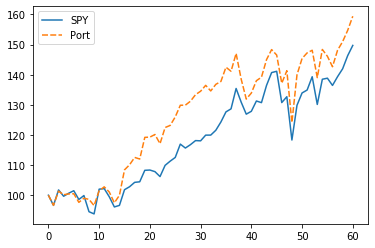

In [74]:
sns.lineplot(data=compare_df)

In [69]:
port.blacklist

{'ADS', 'BKR', 'JNPR', 'TFC', 'TPR', 'TT', 'TWX'}

In [62]:
months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
month_dict = {}
for i in range(len(months)):
    month_dict[months[i]] = i

In [63]:
month_dict['2016-03-01']

14

In [70]:
port.specific_returns[month_dict['2019-01-01']]

{'LONG': {'CI': 0.06454879803848401,
  'EXC': 0.06640075082121083,
  'D': -0.01620648259303719,
  'MNST': 0.1787479406919275,
  'RSG': 0.07488165256060843,
  'NVDA': 0.10039233787214387,
  'RCL': 0.24538230240549821,
  'HIG': 0.0768681580199904,
  'VTR': 0.11160714285714286,
  'MMM': 0.06646102075154231,
  'SRE': 0.08343759022230779,
  'PWR': 0.19246435845213855,
  'CB': 0.042277339346110485,
  'GWW': 0.05918623541574373,
  'WMB': 0.2353540499235864,
  'TROW': 0.035929531757069935,
  'CMG': 0.23789823060561446,
  'ADP': 0.08268692522990795,
  'PXD': 0.10516342965419227,
  'KMI': 0.19047619047619047,
  'XRX': 0.4485530546623795,
  'MLM': 0.04205551567360613,
  'WHR': 0.27634779083907574,
  'KO': 0.025279642058165446,
  'LEG': 0.15800540702913782},
 'SHORT': {'CI': 0.11824618059868333,
  'EXC': 0.03862416653114328,
  'D': 0.02524228082037423}}

In [50]:
sum([x[1] for x in port.specific_returns[month_dict['2016-03-01']]['LONG'].items()])/15

-0.036327608204648455

In [71]:
port.specific_returns

[{'LONG': {'RCL': -0.08909265088271509,
   'WDC': -0.13039704925146461,
   'MMM': -0.01458716895623851,
   'VTR': 0.1101123595505618,
   'HIG': -0.07242116515232498,
   'PWR': -0.07299012693935121,
   'NVDA': -0.04641567818463136,
   'D': -0.004719283970707994,
   'RSG': -0.014610845743186374,
   'CI': 0.030730575956706536,
   'EXC': -0.027833001988071565,
   'TWX': -0.08768438304846633,
   'MAS': -0.02163461538461535,
   'MNST': 0.06882369070468873,
   'INTU': -0.05853379152348224,
   'CNX': -0.14372542009295672,
   'WAT': 0.04825217927269529,
   'BAX': -0.044836956521739094,
   'AIG': -0.13548387096774192,
   'PM': -0.016674683341349996,
   'BIIB': 0.13510675533776703,
   'STT': -0.09723410322212718,
   'AES': -0.11827956989247314,
   'IVZ': -0.0754843019372078,
   'LIN': -0.06977556545279896},
  'SHORT': {'RCL': -0.17417061611374407,
   'WDC': 0.024091482521466714,
   'MMM': -0.003794166469053917}},
 {'LONG': {'WDC': 0.09986337100981234,
   'RCL': 0.02030610698590701,
   'PWR': 0.07

In [9]:
# for key in port.__dict__.keys():
#     if key != 'portfolio':
#         print(key, port.__dict__[key])